In [9]:
from pathlib import Path
import torch
import numpy as np
import matplotlib.pyplot as plt

data_dir = "outputs/rebasin/exp_4/"
data_dir = "outputs/rebasin/exp_4/"

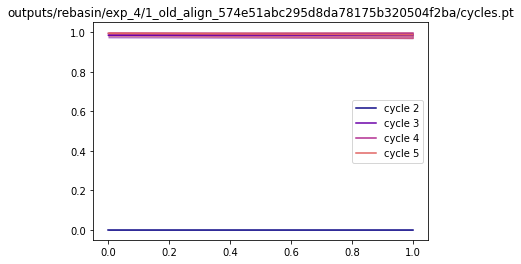

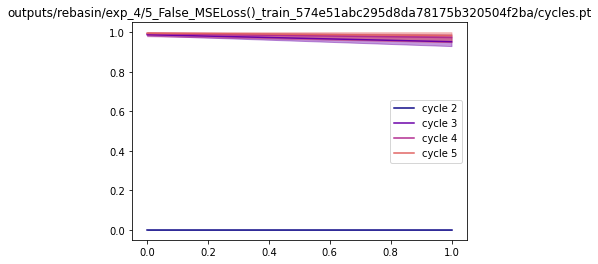

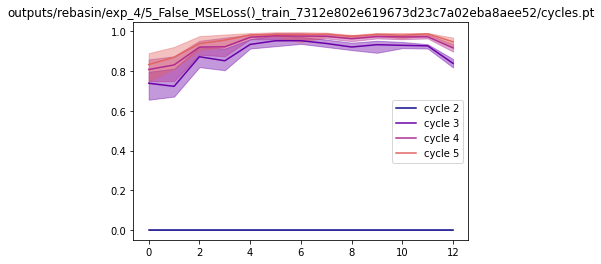

In [10]:
def plot_range(array, name, color):
    x = np.arange(array.shape[0])
    avg = np.mean(array, axis=1)
    lo = np.min(array, axis=1)
    hi = np.max(array, axis=1)
    plt.plot(x, avg, c=color, label=name)
    plt.fill_between(x, lo, hi, color=color, alpha=0.4)

# plot total deviation from identity as function of cycle length and layer depth
def plot_diff_from_identity(cycle_perms, title):
    cycle_len = max([len(x) for x in cycle_perms.keys()])
    dev_freq = [[] for _ in range(cycle_len - 1)]
    for k, v in cycle_perms.items():
        layer_freq = []
        for i, layer in enumerate(v):
            if layer is not None:
                diffs = np.count_nonzero(layer - np.arange(len(layer)))
                layer_freq.append(diffs / len(layer))
        dev_freq[len(k) - 2].append(layer_freq)
    # freq to cycle length
    cmap = plt.get_cmap("plasma")
    for i, freqs in enumerate(dev_freq):
        freqs = np.array(freqs).T
        plot_range(freqs, f"cycle {i + 2}", cmap(i / cycle_len))
    plt.legend()
    plt.title(title)
    plt.show()

for file in Path(data_dir).glob("*/cycles.pt"):
    cycles = torch.load(file)
    plot_diff_from_identity(cycles["cycle_perms"], file)

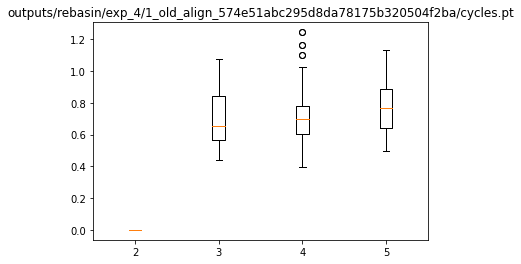

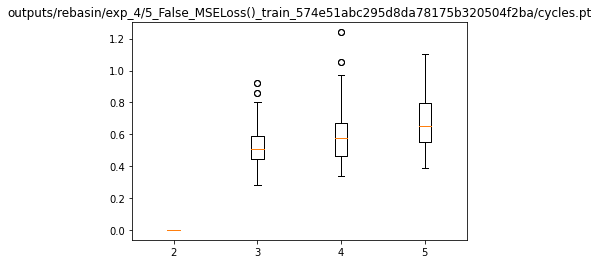

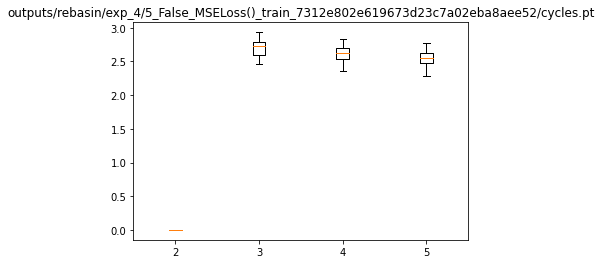

In [11]:
# plot errors as function of cycle length
from nnperm_utils import error_barrier_from_losses

def plot_errors(cycle_perms, title):
    cycle_len = max([len(x) for x in cycle_perms.keys()])
    errors = [[] for _ in range(cycle_len - 1)]
    for k, v in cycle_perms.items():
        barrier = error_barrier_from_losses(v, reduction="mean")
        errors[len(k) - 2].append(np.max(barrier))
    # freq to cycle length
    cmap = plt.get_cmap("plasma")
    for i, err in enumerate(errors):
        plt.boxplot(np.array(err), positions=[i + 2])
    plt.title(title)
    plt.show()

for file in Path(data_dir).glob("*/cycles.pt"):
    cycles = torch.load(file)
    plot_errors(cycles["errors"], file)

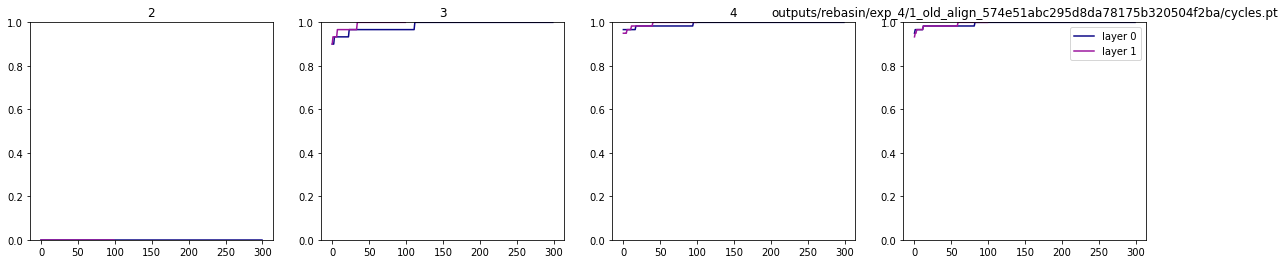

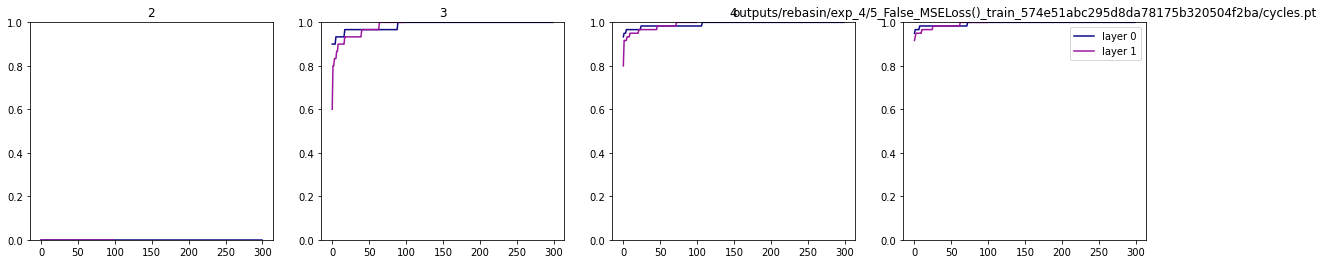

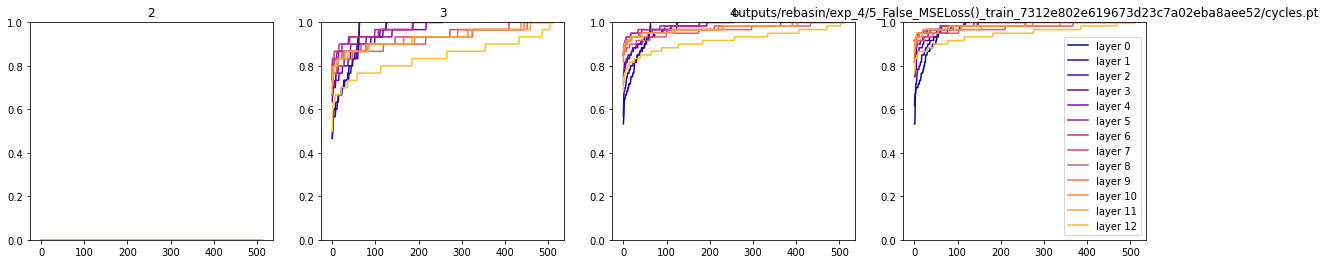

In [12]:
# plot distribution of deviation over weights (ordered by frnp

def plot_diff_distribution(ax, cycle_perms, cycle_len):
    layers = cycle_perms[next(iter(cycle_perms.keys()))]
    n_layers = len(layers)
    n_cycles = 0
    dev_by_layer = [np.zeros_like(layer) for layer in layers[:-1]]
    for k, v in cycle_perms.items():
        if len(k) == cycle_len:
            n_cycles += 1
            for i, layer in enumerate(v):
                if layer is not None:
                    nonzeros = (layer - np.arange(len(layer)) != 0) * 1.
                    dev_by_layer[i] = dev_by_layer[i] + nonzeros.detach().cpu().numpy()
    # sort by nonzeros
    cmap = plt.get_cmap("plasma")
    for i, layer in enumerate(dev_by_layer):
        freqs = np.sort(np.array(layer)) / n_cycles
        ax.plot(freqs, c=cmap(i / n_layers), label=f"layer {i}")
    ax.set_ylim((0, 1))
    ax.set_title(cycle_len)

def plot_dists(cycle_perms, title):
    cycle_len = max([len(x) for x in cycle_perms.keys()])
    fig, axes = plt.subplots(nrows=1, ncols=cycle_len - 1, figsize=(4*cycle_len, 4))
    for i, ax in zip(range(2, cycle_len + 1), axes):
        plot_diff_distribution(ax, cycle_perms, i)
    plt.legend()
    plt.title(title)
    plt.show()

for file in Path(data_dir).glob("*/cycles.pt"):
    cycles = torch.load(file)
    plot_dists(cycles["cycle_perms"], file)